In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/medicaltranscriptions/mtsamples.csv


In [6]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [7]:
!pip install accelerate bitsandbytes

In [8]:
!pip install transformers -q
!pip install language_tool_python -q

import numpy as np
import pandas as pd
import os
import csv
import nltk
import string
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')

from bs4 import BeautifulSoup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch import tensor
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
# AdamW
import tqdm
import numpy as np
from nltk.tokenize import sent_tokenize
from transformers import BertTokenizer, BertModel, AdamW
import random
import sklearn
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from transformers import BartForConditionalGeneration, AutoTokenizer

In [144]:
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
import nltk

# Download NLTK data
nltk.download("punkt")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
medical_df=pd.read_csv('/kaggle/input/medicaltranscriptions/mtsamples.csv',index_col=0)
medical_df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [12]:
medical_df.describe()

,description,medical_specialty,sample_name,transcription,keywords
count,4999,4999,4999,4966,3931
unique,2348,40,2377,2357,3849
top,An example/template for a routine normal male...,Surgery,Lumbar Discogram,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO...",
freq,12,1103,5,5,81


In [13]:
medical_df['transcription'][0]

'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,

In [14]:
medical_df['keywords'][0]

'allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,'

In [15]:
medical_df.isna().sum()

description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

In [16]:
medical_df.shape

(4999, 5)

#### REMOVING NULL VALUES

In [17]:
medical_df = medical_df[medical_df['transcription'].notna() & medical_df['keywords'].notna()]


In [18]:
medical_df.shape

(3898, 5)

#### NEW DATAFRAME OF TRANSCRIPTIONS ANS KEYWORDS

In [19]:
columns=['transcription','keywords']
medical_df=medical_df[columns]

In [20]:
medical_df.head()

,transcription,keywords
0,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


## PREPROCESSING TRANSCRIPTIONS

In [21]:
punct = string.punctuation
punct = punct.replace('.', '')
punct += '@'

def tokenize(text):
    # text = text.strip()
    return word_tokenize(text)

def get_lower(text):
    return text.lower()

def remove_punctuations(text):
    return ''.join([char for char in text if char not in punct])

def remove_alpha_numeric(sentence):
    words = sentence.split()
    alphabetic_words = [word for word in words if word.isalpha()]
    return ' '.join(alphabetic_words)

def remove_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

def remove_extra_gaps(text):
    return ' '.join(text.split())

def pipeline(text):
    text = get_lower(text)
#     text = remove_punctuations(text)
    text = remove_extra_gaps(text)
    return text

In [22]:
medical_df['transcription']=medical_df['transcription'].apply(pipeline)

In [23]:
medical_df.head()

,transcription,keywords
0,"subjective:, this 23-year-old white female pre...","allergy / immunology, allergic rhinitis, aller..."
1,"past medical history:, he has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,"history of present illness: , i have seen abc ...","bariatrics, laparoscopic gastric bypass, heart..."
3,"2-d m-mode: , ,1. left atrial enlargement with...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,1. the left ventricular cavity size and wall t...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


# Key Word extraction Using Bert without fine_tuning

In [121]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


n_gram_range = (1, 1)
stop_words = "english"
model_sent = SentenceTransformer('distilbert-base-nli-mean-tokens')
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([medical_df.iloc[10]['transcription']])
candidates = count.get_feature_names_out()
doc_embedding = model_sent.encode([medical_df.iloc[10]['transcription']])
candidate_embeddings = model_sent.encode(candidates)
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-20:]]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [122]:
print(keywords)

['supine', 'decompression', 'umbilicus', 'anesthesia', '50', 'male', 'compression', 'years', 'weight', 'laparoscopic', 'surgery', 'catheter', 'postoperative', 'bariatric', 'endotracheal', 'esophagogastroduodenoscopy', 'old', 'gastric', 'overweight', 'obesity']


In [123]:
medical_df.iloc[10]['keywords']

'bariatrics, morbid obesity, roux-en-y, gastric bypass, antecolic, antegastric, anastamosis, esophagogastroduodenoscopy, eea, surgidac sutures, roux limb, port, stapler, laparoscopic, intubation'

#### EXAMPLE 1

In [126]:
count_100 = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([medical_df.iloc[20]['transcription']])
candidates_100 = count_100.get_feature_names_out()
doc_embedding_100 = model_sent.encode([medical_df.iloc[20]['transcription']])
candidate_embeddings_100 = model_sent.encode(candidates_100)
distances_100 = cosine_similarity(doc_embedding_100, candidate_embeddings_100)
keywords = [candidates_100[index] for index in distances_100.argsort()[0][-20:]]

print(keywords)
print(medical_df.iloc[20]['keywords'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

['final', 'wound', 'ounces', '30', 'med', 'hour', 'apnea', 'sleep', 'tomorrow', 'hospital', 'cardiopulmonary', 'laparoscopic', 'meds', 'old', 'bariatric', 'postoperative', 'hypertension', 'surgery', 'gastric', 'obesity']
bariatrics, medifast, laparoscopic roux-en-y gastric bypass, roux-en-y, bariatric clear liquids, gastric bypass, laparoscopic, gastric, bariatric, bypass, 


#### EXAMPLE 2

In [128]:
count_100 = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([medical_df.iloc[300]['transcription']])
candidates_100 = count_100.get_feature_names_out()
doc_embedding_100 = model_sent.encode([medical_df.iloc[300]['transcription']])
candidate_embeddings_100 = model_sent.encode(candidates_100)
distances_100 = cosine_similarity(doc_embedding_100, candidate_embeddings_100)
keywords = [candidates_100[index] for index in distances_100.argsort()[0][-20:]]

print(keywords)
print(medical_df.iloc[20]['keywords'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

['bleeding', 'colotomy', 'endoscopically', 'postoperative', 'diaphragm', 'peritoneal', 'catheter', 'endotracheal', 'gastrotomy', 'surgical', 'gastrostomy', 'endoscopic', 'biopsy', 'lysis', 'anesthesia', 'endoscope', 'hemostasis', 'chemotherapy', 'endoscopy', 'carcinoma']
bariatrics, medifast, laparoscopic roux-en-y gastric bypass, roux-en-y, bariatric clear liquids, gastric bypass, laparoscopic, gastric, bariatric, bypass, 


# FINE TUNING BERT FOR KEYWORDS EXTRACTION

#### Finding the length distribution of transcription

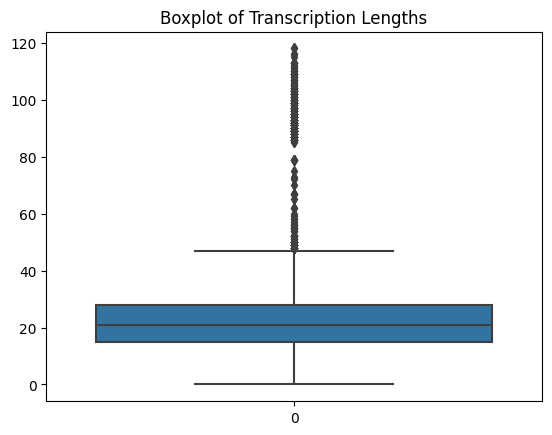

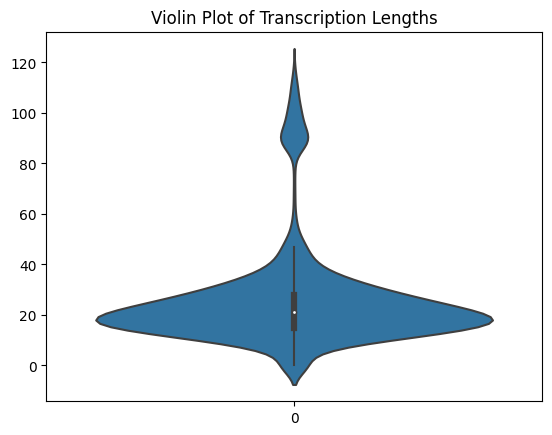

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


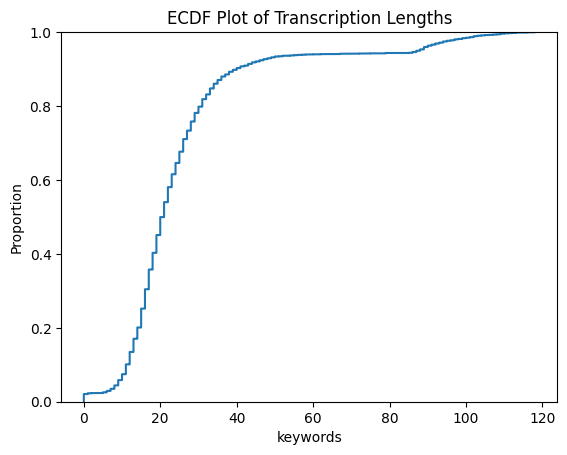

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


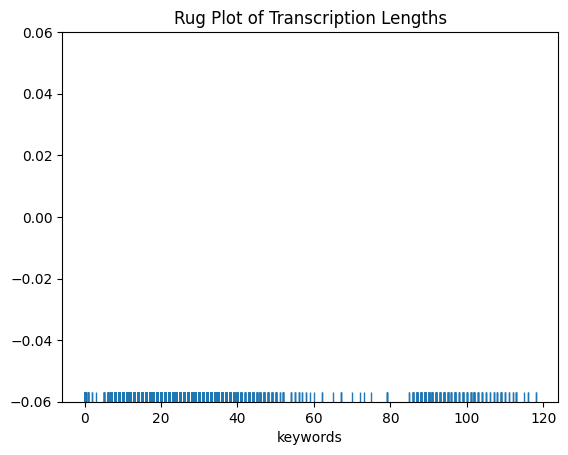

In [117]:
keywords = medical_df['keywords'].apply(lambda x: len(x.split()))


sns.boxplot(keywords)
plt.title('Boxplot of Transcription Lengths')
plt.show()

# Violin Plot
sns.violinplot(keywords)
plt.title('Violin Plot of Transcription Lengths')
plt.show()

# ECDF Plot
sns.ecdfplot(keywords)
plt.title('ECDF Plot of Transcription Lengths')
plt.show()

# Rug Plot
sns.rugplot(keywords)
plt.title('Rug Plot of Transcription Lengths')
plt.show()

#### Length distribution of keywords

/tmp/ipykernel_42/2660214344.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(keywords)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


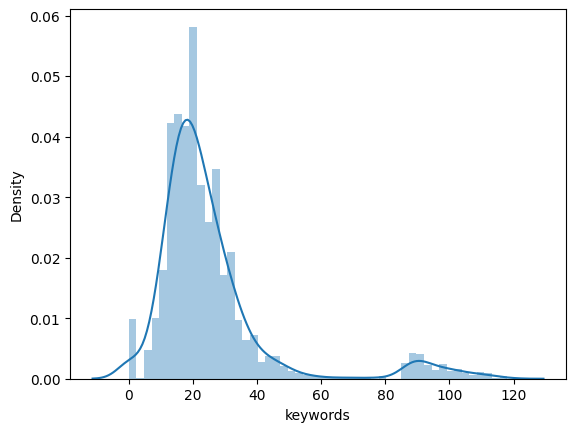

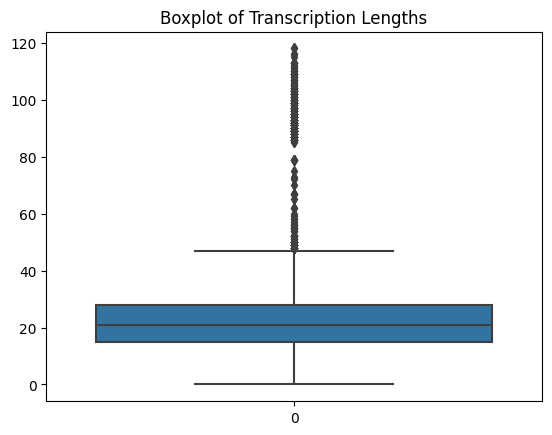

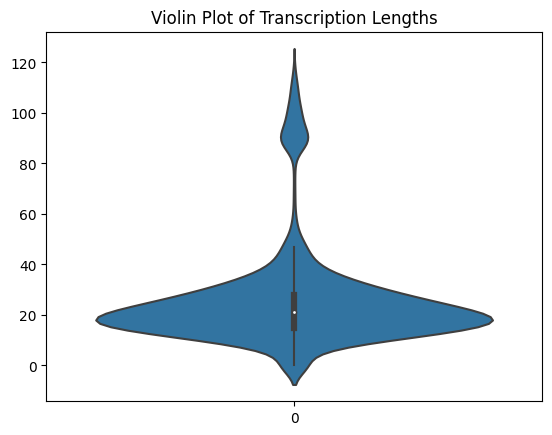

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


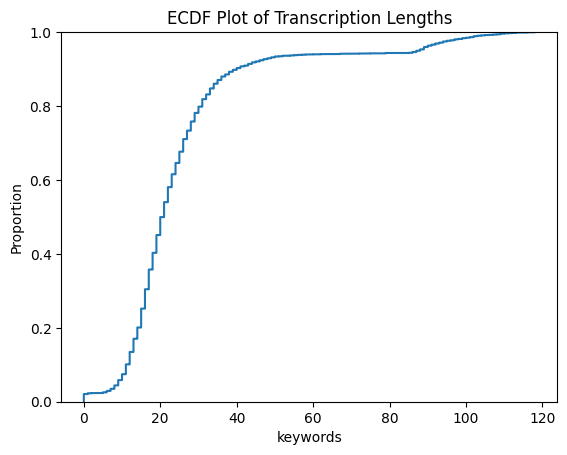

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


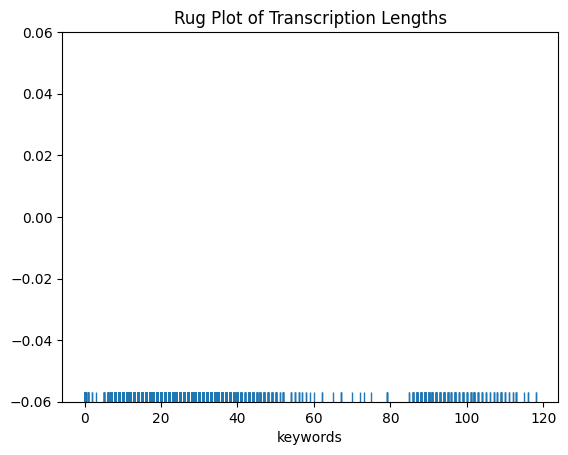

In [119]:
keywords = medical_df['keywords'].apply(lambda x: len(x.split()))

sns.distplot(keywords)
plt.show()

sns.boxplot(keywords)
plt.title('Boxplot of Transcription Lengths')
plt.show()

# Violin Plot
sns.violinplot(keywords)
plt.title('Violin Plot of Transcription Lengths')
plt.show()

# ECDF Plot
sns.ecdfplot(keywords)
plt.title('ECDF Plot of Transcription Lengths')
plt.show()

# Rug Plot
sns.rugplot(keywords)
plt.title('Rug Plot of Transcription Lengths')
plt.show()

In [71]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base", padding_side="left",
                                         truncation_side='right')
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to("cuda")

In [98]:
class MedicalDataset(Dataset):
    def __init__(self, df,tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        transcript=self.df['transcription']
        keywords=self.df['keywords']
        
        transcript_tokens = self.tokenizer(transcript.iloc[idx],
                                          padding='max_length',
                                          truncation=True, 
                                          max_length=1000,
                                          return_tensors='pt')
        transcript_tokens=transcript_tokens['input_ids']
        
        keyword_tokens = self.tokenizer(keywords.iloc[idx],
                                       padding="max_length", truncation=True,
                                       max_length=50,
                                       return_tensors='pt')
        keyword_tokens=keyword_tokens['input_ids']
        
        transcript_tokens = transcript_tokens.to("cuda")
        keyword_tokens = keyword_tokens.to("cuda")

        return transcript_tokens[0,:], keyword_tokens[0,:]
        


In [ ]:
df_train, df_test = train_test_split(medical_df, train_size=0.7)

batch_size = 4

ds_train = MedicalDataset(df_train,tokenizer)
ds_test = MedicalDataset(df_test,tokenizer)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

In [99]:
from torch.optim import Adam

optimizer = Adam(model.parameters(),lr=2e-4)

def num_batches(total, batch_size):
    if total % batch_size == 0:
        return total // batch_size
    else:
        return total // batch_size + 1
    

train_batches = num_batches(df_train.shape[0],batch_size)
test_batches = num_batches(df_test.shape[0],batch_size)

In [100]:
def train(data,num_batches, model, optimizer):
    model.train()
    model_loss = 0
    model_acc = 0
    i = 0
    for transcription, keyword in data:
        optimizer.zero_grad()
        out = model(transcription, labels=keyword)
        
        loss = out.loss
        model_loss += loss.item()
        
        logits = out.logits
        preds = torch.argmax(torch.softmax(logits,dim=2),dim=2)
        acc = torch.sum(keyword == preds).item()/(keyword.shape[0]*keyword.shape[1])
        model_acc += acc
        
        loss.backward()
        optimizer.step()
        
        i+=1
    
    print(f"loss={model_loss/i} accuracy={model_acc/i}",end="\n")

In [101]:
def test(dataloader,num_batches, model):
    model.eval()
    model_loss = 0
    model_acc = 0
    i = 0
    
    for transcription, keyword in dataloader:
        out = model(transcription, labels=keyword)
        
        loss = out.loss
        model_loss += loss.item()
        
        logits = out.logits
        preds = torch.argmax(torch.softmax(logits,dim=2),dim=2)
        acc = torch.sum(keyword == preds).item()/(keyword.shape[0]*keyword.shape[1])
        model_acc += acc
        i+=1
    
    print(f"loss={model_loss/i} accuracy={model_acc/i}",end="\n")


In [102]:
for e in range(3):
    train(dl_train,train_batches,model, optimizer)
    test(dl_test, test_batches,model)

loss=0.9734919249603659 accuracy=0.7665735461801583
loss=0.9406490873317329 accuracy=0.7882142857142856
loss=0.6940550941765784 accuracy=0.8157867730900815
loss=0.728605892281143 accuracy=0.8271428571428571
loss=0.5781295233094977 accuracy=0.8423489167616899
loss=0.68831311652855 accuracy=0.836530612244898


In [104]:
torch.save({
    'epoch': 3,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, '/kaggle/working/model.pth')


In [108]:
def summary(df, transcription, model, tokenizer):
    df['Result'] = df[transcription].apply(lambda x: text(x, model, tokenizer))
    return df

def text(text, model, tokenizer):
    input_ids = tokenizer(text, max_length=1000, padding='max_length', truncation=True, return_tensors='pt')['input_ids'].to("cuda")
    generated_ids = model.generate(input_ids, min_length=20, max_length=50)
    decoded_keywords = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    return decoded_keywords




In [109]:
results = summary(df_test,'transcription',model,tokenizer)

## Test Results

#### 1

#### BART RESULTS

In [110]:
print(results['Result'].iloc[0])

['ophthalmology, intraocular lens implant, posterior chamber intraocular, phacoemulsification, posterior pole, anterior capsular, capsulorrhexis, max oil cataract extraction, retinal detachment, anterior chamber,']


#### GROUND TRUTH

In [111]:
print(results['keywords'].iloc[0])

surgery, phacoemulsification, intraocular lens implant, posterior chamber, chamber, eye, intraocular, lens,


#### 2

#### BART RESULTS

In [112]:
print(results['Result'].iloc[1])

['gastroenterology, ablation of endometriosis, laparoscopy, uterosacral ligament, endometrialosis, endobronchial ligamentation, uteroacral, ligament']


#### Ground truth

In [113]:
print(results['keywords'].iloc[1])

obstetrics / gynecology, ablation of endometriosis, allen-masters window, uterosacral ligament, endometriosis, cul de sac, laparoscopy, lesions, ablation


### 3

#### BART RESULTS

In [114]:
print(results['Result'].iloc[2])

['consult - history and phy., child physical examination, physical exam, hemipitofrontal circumference, child physical, physical, normal male, male physical, male, sutures, extremity, head, lacunar']


#### GROUND TRUTH

In [115]:
print(results['keywords'].iloc[2])

office notes, child physical examination, physical, genitalia, child, 


# KEYWORD EXTRACTION USING KEYBERT

In [129]:
pip install keybert

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for keybert: filename=keybert-0.8.3-py3-none-any.whl size=39124 sha256=19fb6ed1fb1add1e5bab68d5da3068cf69d3034afa06697a14618f3bdf810796
  Stored in directory: /root/.cache/pip/wheels/70/88/07/1a3bc11fd1dd5f89924a02dcbca89a3015e25e8faa31f904dc
Successfully built keybert
Note: you may need to restart the kernel to use updated packages.


In [130]:
from keybert import KeyBERT

In [131]:
kw_model = KeyBERT()

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

#### Groundtruth

In [135]:
medical_df.iloc[10]['keywords']

'bariatrics, morbid obesity, roux-en-y, gastric bypass, antecolic, antegastric, anastamosis, esophagogastroduodenoscopy, eea, surgidac sutures, roux limb, port, stapler, laparoscopic, intubation'

#### USING MAXSUM

In [140]:
print(kw_model.extract_keywords(medical_df.iloc[10]['transcription'], keyphrase_ngram_range=(1, 2), stop_words='english',
                              use_maxsum=True, nr_candidates=20, top_n=10))

[('postoperative diagnosis', 0.4014), ('procedure laparoscopic', 0.4054), ('anesthesia general', 0.4094), ('obesity', 0.4167), ('esophagogastroduodenoscopy', 0.4376), ('en gastric', 0.4452), ('laparoscopic roux', 0.4615), ('anastamosis esophagogastroduodenoscopy', 0.4633), ('morbid obesity', 0.4751), ('bariatric seminar', 0.508)]


#### USING MAXIMAL MARGINAL RELEVANCE

In [138]:
print(kw_model.extract_keywords(medical_df.iloc[10]['transcription'], keyphrase_ngram_range=(1, 2), stop_words='english',
                              use_mmr=True, diversity=0.7))

[('obesity postoperative', 0.6884), ('eea anastamosis', 0.2951), ('comorbidities related', 0.1013), ('sequential compression', 0.0419), ('signing consent', 0.0164)]


#### LOW DIVERSITY

In [141]:
print(kw_model.extract_keywords(medical_df.iloc[10]['transcription'], keyphrase_ngram_range=(1, 2), stop_words='english',
                              use_mmr=True, diversity=0.1))

[('obesity postoperative', 0.6884), ('gastric bypass', 0.6823), ('obesity procedure', 0.6608), ('obesity patient', 0.6065), ('bypass surgery', 0.6023)]


In [146]:
pip install rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=51880e5af5c48d158c8a482cbe8292fc122db370e1562c1d4c46c7ffd65e7bcd
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [149]:
pip install rouge


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [157]:
def cal(ground_truth, prediction):
    reference = nltk.word_tokenize(ground_truth.lower())
    candidate = nltk.word_tokenize(prediction.lower())
    smoothing_function = SmoothingFunction().method1
    scores = corpus_bleu([ground_truth], [prediction], smoothing_function=smoothing_function)
    return scores

#### COMPARISON BETWEEN BERT AND BART

#### KEYBERT

In [170]:
count_100 = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([medical_df.iloc[10]['transcription']])
candidates_100 = count_100.get_feature_names_out()
doc_embedding_100 = model_sent.encode([medical_df.iloc[10]['transcription']])
candidate_embeddings_100 = model_sent.encode(candidates_100)
distances_100 = cosine_similarity(doc_embedding_100, candidate_embeddings_100)
keywords = [candidates_100[index] for index in distances_100.argsort()[0][-50:]]



cal(medical_df.iloc[10]['keywords'],' '.join(keywords))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

0.0008329157525953993

#### BART

In [167]:
cal(results['keywords'].iloc[1],' '.join(results['Result'].iloc[1]))

0.0026025713943907936